In [1]:
import os
import gsw
import pandas as pd
import numpy as np
import time
import glob
from scipy.optimize import curve_fit
import scipy as sp
from scipy import interpolate
from scipy.interpolate import griddata
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cm
from tqdm import tqdm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import radians, degrees, sin, cos, asin, acos, sqrt
import momlevel
import doralite
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [2]:
def query_ondisk(path):
    cmd = ("dmls -l " + path)
    outputs = os.popen(cmd).read().split('\n')
    ondisk = {}
    for output in outputs[:-1]:
        if '(DUL)' in output:
            ondisk[output.split(' ')[-1]]=True
        else:
            ondisk[output.split(' ')[-1]]=False
    return ondisk
def issue_dmget(path):
    cmd = ("dmget " + path + " &")
    out = os.system(cmd)
    return out
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )
def cart2pol(x, y):
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return rho, phi
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

In [6]:
exps = ["odiv-231","odiv-255"] # CM4X p25, p125 (unique file path structure)
ys = '2000'; ye = '2010';
# -- subset for faster calculations
slx = -70 # center longitude
sly = 32 # center latitude

In [7]:
%%time
# -- for CM4X ONLY as file path structure is different -- takes a while to load in this manner 
sc = 20; # number of degrees lat/lon to slice model domain (for faster subsequent calculations)
out_dict = {}
sg = xr.load_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc')
fl = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/*.vo.nc'))
fl2 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/*.uo.nc'))
fl3 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/*.zos.nc'))
fl4 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/*.tos.nc'))
oisst_p25_fp = '/archive/Raphael.Dussin/datasets/NOAA_OIv2/NOAA_OIv2_sst.mon.mean.grid_CM4p25.nc'; # OISST on cm4x grid -  p25
sg_geolon = sg.geolon; sg_geolat = sg.geolat
ii = np.where((sg_geolon > (slx - sc)) & (sg_geolon < (slx + sc)) & (sg_geolat > (sly - sc)) & (sg_geolat < (sly + sc)))
ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];

ds = xr.open_mfdataset(fl, use_cftime=True); ds2 = xr.open_mfdataset(fl2, use_cftime=True); ds3 = xr.open_mfdataset(fl3, use_cftime=True); ds4 = xr.open_mfdataset(fl4, use_cftime=True)
ds_obs = xr.open_mfdataset(oisst_p25_fp, use_cftime=True)
out_dict[exps[0]] = {'vo_m': ds.vo.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yq=slice(iys,iye)).mean(dim='time').load(), \
                     'uo_m': ds2.uo.sel(time=slice(ys,ye)).isel(xq=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'zos_m': ds3.zos.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'tos_m': ds4.tos.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'obs_sst_m': ds_obs.sst.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'geolon': sg.geolon.isel(xh=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolat': sg.geolat.isel(xh=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolon_v': sg.geolon_v.isel(xh=slice(ixs,ixe),yq=slice(iys,iye)), \
                     'geolat_v': sg.geolat_v.isel(xh=slice(ixs,ixe),yq=slice(iys,iye)), \
                     'geolon_u': sg.geolon_u.isel(xq=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolat_u': sg.geolat_u.isel(xq=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'dep': sg.deptho.isel(xh=slice(ixs,ixe),yh=slice(iys,iye))}

sg125 = xr.load_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_z/ocean_month_z.static.nc')
fl = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/*.vo.nc'))
fl2 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/*.uo.nc'))
fl3 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/*.zos.nc'))
fl4 = sorted(glob.glob('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/*.tos.nc'))
oisst_p125_fp = '/archive/Raphael.Dussin/datasets/NOAA_OIv2/NOAA_OIv2_sst.mon.mean.grid_CM4p125.nc'
sg_geolon = sg125.geolon; sg_geolat = sg125.geolat
ii = np.where((sg_geolon > (slx - sc)) & (sg_geolon < (slx + sc)) & (sg_geolat > (sly - sc)) & (sg_geolat < (sly + sc)))
ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];
ds = xr.open_mfdataset(fl, use_cftime=True); ds2 = xr.open_mfdataset(fl2, use_cftime=True); ds3 = xr.open_mfdataset(fl3, use_cftime=True); ds4 = xr.open_mfdataset(fl4, use_cftime=True)
ds_obs = xr.open_mfdataset(oisst_p125_fp, use_cftime=True)
out_dict[exps[1]] = {'vo_m': ds.vo.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yq=slice(iys,iye)).mean(dim='time').load(), \
                     'uo_m': ds2.uo.sel(time=slice(ys,ye)).isel(xq=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'zos_m': ds3.zos.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'tos_m': ds4.tos.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'obs_sst_m': ds_obs.sst.sel(time=slice(ys,ye)).isel(xh=slice(ixs,ixe),yh=slice(iys,iye)).mean(dim='time').load(), \
                     'geolon': sg125.geolon.isel(xh=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolat': sg125.geolat.isel(xh=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolon_v': sg125.geolon_v.isel(xh=slice(ixs,ixe),yq=slice(iys,iye)), \
                     'geolat_v': sg125.geolat_v.isel(xh=slice(ixs,ixe),yq=slice(iys,iye)), \
                     'geolon_u': sg125.geolon_u.isel(xq=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'geolat_u': sg125.geolat_u.isel(xq=slice(ixs,ixe),yh=slice(iys,iye)), \
                     'dep': sg125.deptho.isel(xh=slice(ixs,ixe),yh=slice(iys,iye))}

CPU times: user 4min 22s, sys: 10min 54s, total: 15min 16s
Wall time: 20min 23s


In [8]:
# NOAA OISST (on CM4X grids)
oisst_p25_fp = '/archive/Raphael.Dussin/datasets/NOAA_OIv2/NOAA_OIv2_sst.mon.mean.grid_CM4p25.nc'; # p25
oisst_p125_fp = '/archive/Raphael.Dussin/datasets/NOAA_OIv2/NOAA_OIv2_sst.mon.mean.grid_CM4p125.nc'; # p125
oisst_p25 = xr.open_dataset(oisst_p25_fp)
oisst_p125 = xr.open_dataset(oisst_p125_fp)

In [9]:
# -- Regional Model NWA12 (30yr historical) --
main_dir = '/archive/acr/fre/NWA/2024_01/NWA12_physics_2024_01_bcsupdate_chassignet2017v4/gfdl.ncrc5-intel22-prod/' # Andrew's best - his rec
rm_static_grids = xr.load_dataset(main_dir + '/pp/ocean_monthly/ocean_monthly.static.nc')
yso = '2000'; yeo = '2010'; # OVERRIDE - alignment/overlap w/ NWA12
S3 = xr.open_dataset(main_dir + 'pp/ocean_monthly/ts/monthly/30yr/ocean_monthly.199301-202212.ssh.nc') # monthly
ssh = S3.ssh.sel(time=slice(yso,yeo)).load()
vo3 = xr.open_dataset(main_dir + 'pp/ocean_monthly_z/ts/monthly/30yr/ocean_monthly_z.199301-202212.vo.nc') # monthly
vo = vo3.vo.sel(time=slice(yso,yeo)).load()
uo3 = xr.open_dataset(main_dir + 'pp/ocean_monthly_z/ts/monthly/30yr/ocean_monthly_z.199301-202212.uo.nc') # monthly
uo = uo3.uo.sel(time=slice(yso,yeo)).load()
tos3 = xr.open_dataset(main_dir + 'pp/ocean_monthly/ts/monthly/30yr/ocean_monthly.199301-202212.tos.nc') # monthly
tos = tos3.tos.sel(time=slice(yso,yeo)).load()

# load NWA12 - take time mean
nwa12_vo_m = vo.mean(dim='time')
nwa12_uo_m = uo.mean(dim='time')
nwa12_tos_m = tos.mean(dim='time')

In [10]:
# load Observed MKE and velocities (Todd 2021)
gs_mke_todd = xr.open_dataset('/net/jms/obs/Gulf_Stream_kinetic_energy.nc')

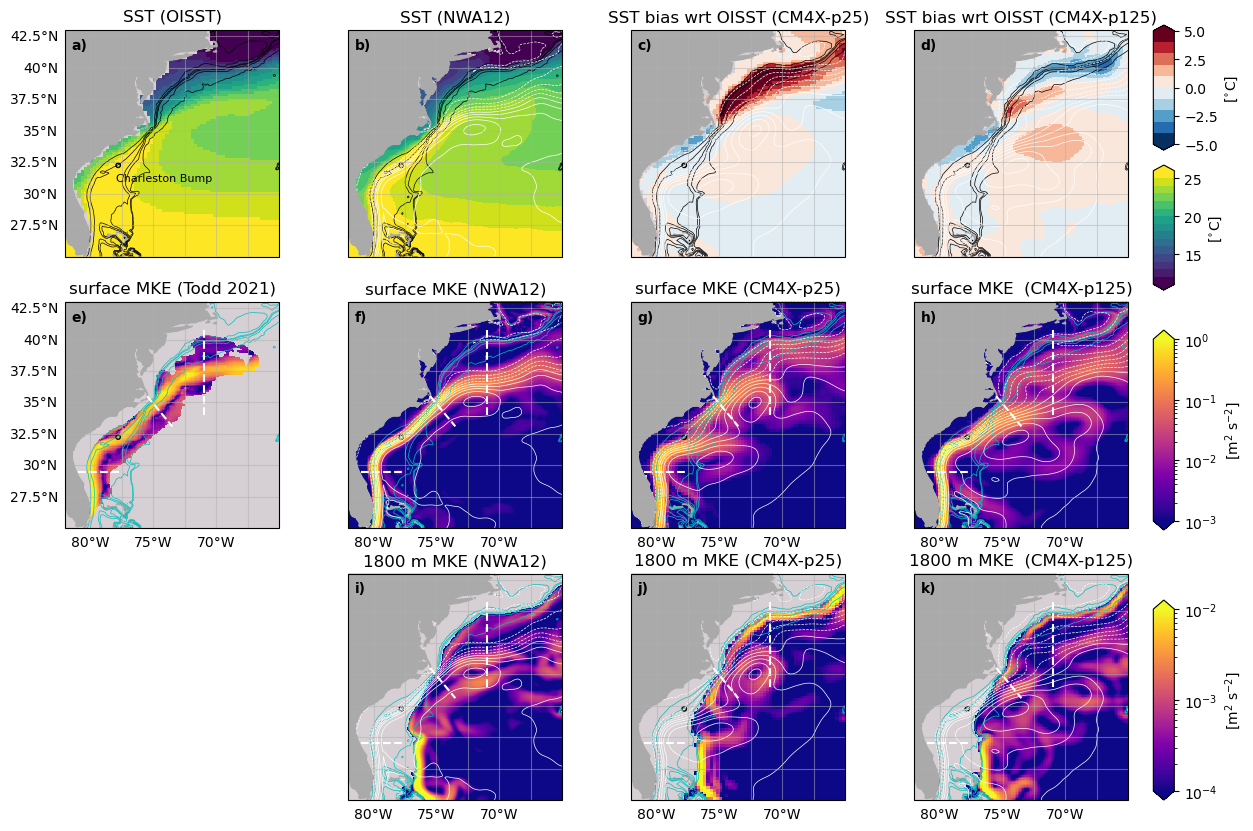

In [11]:
la_cross = 29.5; lo_cross = -71
mid_cross_la = np.arange(35.5, 33, -0.1); mid_cross_lo = np.linspace(-75.5, -73.5, len(mid_cross_la)) # CAPE HATTERAS
lon_w = -82; lon_e = -65; lat_s = 25; lat_n = 43; levs=np.arange(0,1+0.1,0.1); land_co = '#aaaaaa'; back_co = '#D6CFD3'
f, ax = plt.subplots(3,4,figsize=(14,10),subplot_kw={'projection':ccrs.PlateCarree()});

# OBS
cc00 = ax[0,0].pcolor(oisst_p25.lon, oisst_p25.lat, oisst_p25.sst.sel(time=slice('2000','2010')).mean(dim='time'), transform=ccrs.PlateCarree(), vmin=11, vmax=26, cmap=plt.get_cmap('viridis',15), label='');
ax[0,0].contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['dep'],levels=[100,500,1000,2000,3000],colors='k',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,0].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
ax[0,0].text(-78, 31, 'Charleston Bump', fontsize=8, transform=ccrs.PlateCarree())
ax[0,0].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[0,0].set_facecolor(back_co);
ax[0,0].set_xlim([lon_w,lon_e]); ax[0,0].set_ylim([lat_s,lat_n]); ax[0,0].set_title('SST (OISST)');
gl = ax[0,0].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False; gl.bottom_labels = False; 

cc1 = ax[1,0].pcolor(gs_mke_todd.longitude, gs_mke_todd.latitude, gs_mke_todd.mean_kinetic_energy.isel(depth=0), transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.001,vmax=1), cmap=plt.get_cmap('plasma'), label='');
ax[1,0].contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['dep'],levels=[100,500,1000,2000,3000],colors='c',linewidths=0.5, transform=ccrs.PlateCarree())
ax[1,0].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
ax[1,0].plot([-81,-77.5],[la_cross,la_cross],color='w',linestyle='--',transform=ccrs.PlateCarree())
ax[1,0].plot([lo_cross,lo_cross],[34,41],color='w',linestyle='--',transform=ccrs.PlateCarree())
ax[1,0].plot(mid_cross_lo,mid_cross_la,color='w',linestyle='--',transform=ccrs.PlateCarree())
ax[1,0].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[1,0].set_facecolor(back_co);
ax[1,0].set_xlim([lon_w,lon_e]); ax[1,0].set_ylim([lat_s,lat_n]); ax[1,0].set_title('surface MKE (Todd 2021)');
gl = ax[1,0].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False; 

# SST
ax[0,1].pcolor(rm_static_grids.geolon, rm_static_grids.geolat, nwa12_tos_m, transform=ccrs.PlateCarree(), vmin=11, vmax=26, cmap=plt.get_cmap('viridis',15), label=''); 
ax[0,1].contour(rm_static_grids.geolon, rm_static_grids.geolat, rm_static_grids.deptho, levels=[100,500,1000,2000,3000],colors='k',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,1].contour(rm_static_grids.geolon, rm_static_grids.geolat, ssh.mean(dim='time'), levels=np.arange(-1,1.1,0.1), colors='w',linewidths=0.5, transform=ccrs.PlateCarree()) 
ax[0,1].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
ax[0,1].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[0,1].set_facecolor(back_co);
ax[0,1].set_xlim([lon_w,lon_e]); ax[0,1].set_ylim([lat_s,lat_n]); ax[0,1].set_title('SST (NWA12)');
gl = ax[0,1].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False; gl.bottom_labels = False;

cc01 = ax[0,2].pcolor(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['tos_m'].data - out_dict[exps[0]]['obs_sst_m'].data, vmin=-5, vmax=5, cmap=plt.get_cmap('RdBu_r',10), transform=ccrs.PlateCarree())
ax[0,2].contour(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['dep'],levels=[100,500,1000,2000,3000],colors='k',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,2].contour(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['zos_m'],levels=np.arange(-1,1.1,0.1),colors='w',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,2].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
ax[0,2].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[0,2].set_facecolor(back_co);
ax[0,2].set_xlim([lon_w,lon_e]); ax[0,2].set_ylim([lat_s,lat_n]); ax[0,2].set_title('SST bias wrt OISST (CM4X-p25)');
gl = ax[0,2].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False; gl.bottom_labels = False;

ax[0,3].pcolor(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['tos_m'].data - out_dict[exps[1]]['obs_sst_m'].data, vmin=-5, vmax=5, cmap=plt.get_cmap('RdBu_r',10), transform=ccrs.PlateCarree())
ax[0,3].contour(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['dep'],levels=[100,500,1000,2000,3000],colors='k',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,3].contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['zos_m'],levels=np.arange(-1,1.1,0.1),colors='w',linewidths=0.5, transform=ccrs.PlateCarree())
ax[0,3].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
ax[0,3].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[0,3].set_facecolor(back_co);
ax[0,3].set_xlim([lon_w,lon_e]); ax[0,3].set_ylim([lat_s,lat_n]); ax[0,3].set_title('SST bias wrt OISST (CM4X-p125)');
gl = ax[0,3].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False; gl.bottom_labels = False;

depths = [0,24]; depths_nwa = [0,41]; vlim = np.array([[0.001,1],[0.0001,0.01]]); labi = ['surface', '1800 m']
for i in range(2):
    vli = vlim[i,:]
    ax[i+1,1].pcolor(rm_static_grids.geolon, rm_static_grids.geolat, 0.5*(nwa12_vo_m.isel(z_l=depths_nwa[i])[0:-1,:].data**2 + nwa12_uo_m.isel(z_l=depths_nwa[i])[:,0:-1]**2), \
                   transform=ccrs.PlateCarree(), norm=LogNorm(vmin=vli[0],vmax=vli[1]), cmap=plt.get_cmap('plasma'), label=''); 
    ax[i+1,1].contour(rm_static_grids.geolon, rm_static_grids.geolat, rm_static_grids.deptho, levels=[100,500,1000,2000,3000],colors='c',linewidths=0.5, transform=ccrs.PlateCarree())
    ax[i+1,1].contour(rm_static_grids.geolon, rm_static_grids.geolat, ssh.mean(dim='time'), levels=np.arange(-1,1.1,0.1), colors='w',linewidths=0.5, transform=ccrs.PlateCarree())
    if i < 4:
        ax[i+1,1].plot([-81,-77.5],[la_cross,la_cross],color='w',linestyle='--',transform=ccrs.PlateCarree())
        ax[i+1,1].plot([lo_cross,lo_cross],[34,41],color='w',linestyle='--',transform=ccrs.PlateCarree())
        
        ax[i+1,1].plot(mid_cross_lo,mid_cross_la,color='w',linestyle='--',transform=ccrs.PlateCarree())
    ax[i+1,1].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
    ax[i+1,1].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[i+1,1].set_facecolor(back_co);
    ax[i+1,1].set_xlim([lon_w,lon_e]); ax[i+1,1].set_ylim([lat_s,lat_n]); ax[i+1,1].set_title(labi[i] + ' MKE (NWA12)');
    gl = ax[i+1,1].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False;
    
    ax[i+1,2].pcolor(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],0.5*(out_dict[exps[0]]['uo_m'].isel(z_l=depths[i]).data**2 + out_dict[exps[0]]['vo_m'].isel(z_l=depths[i]).data**2),\
                norm=LogNorm(vmin=vli[0],vmax=vli[1]),cmap=plt.get_cmap('plasma'),transform=ccrs.PlateCarree())
    ax[i+1,2].contour(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['dep'],levels=[100,500,1000,2000,3000],colors='c',linewidths=0.5, transform=ccrs.PlateCarree())
    ax[i+1,2].contour(out_dict[exps[0]]['geolon'],out_dict[exps[0]]['geolat'],out_dict[exps[0]]['zos_m'],levels=np.arange(-1,1.1,0.1),colors='w',linewidths=0.5, transform=ccrs.PlateCarree())
    if i < 4:
        ax[i+1,2].plot([-81,-77.5],[la_cross,la_cross],color='w',linestyle='--',transform=ccrs.PlateCarree())
        ax[i+1,2].plot([lo_cross,lo_cross],[34,41],color='w',linestyle='--',transform=ccrs.PlateCarree())
        ax[i+1,2].plot(mid_cross_lo,mid_cross_la,color='w',linestyle='--',transform=ccrs.PlateCarree())
    ax[i+1,2].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
    ax[i+1,2].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[i+1,2].set_facecolor(back_co);
    ax[i+1,2].set_xlim([lon_w,lon_e]); ax[i+1,2].set_ylim([lat_s,lat_n]); ax[i+1,2].set_title(labi[i] + ' MKE (CM4X-p25)');
    gl = ax[i+1,2].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False;

    cc = ax[i+1,3].pcolor(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],0.5*(out_dict[exps[1]]['uo_m'].isel(z_l=depths[i]).data**2 + out_dict[exps[1]]['vo_m'].isel(z_l=depths[i]).data**2),\
            norm=LogNorm(vmin=vli[0],vmax=vli[1]),cmap=plt.get_cmap('plasma'),transform=ccrs.PlateCarree())
    ax[i+1,3].contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['dep'],levels=[100,500,1000,2000,3000],colors='c',linewidths=0.5, transform=ccrs.PlateCarree())
    ax[i+1,3].contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['zos_m'],levels=np.arange(-1,1.1,0.1),colors='w',linewidths=0.5, transform=ccrs.PlateCarree())
    if i < 4:
        ax[i+1,3].plot([-81,-77.5],[la_cross,la_cross],color='w',linestyle='--',transform=ccrs.PlateCarree())
        ax[i+1,3].plot([lo_cross,lo_cross],[34,41],color='w',linestyle='--',transform=ccrs.PlateCarree())
        ax[i+1,3].plot(mid_cross_lo,mid_cross_la,color='w',linestyle='--',transform=ccrs.PlateCarree())
    ax[i+1,3].scatter(-77.8, 32.25, s=10, edgecolor='k', facecolor='none',transform=ccrs.PlateCarree())
    ax[i+1,3].add_feature(cartopy.feature.LAND, color=land_co, zorder=1); ax[i+1,3].set_facecolor(back_co);
    ax[i+1,3].set_xlim([lon_w,lon_e]); ax[i+1,3].set_ylim([lat_s,lat_n]); ax[i+1,3].set_title(labi[i] + ' MKE  (CM4X-p125)');
    gl = ax[i+1,3].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False;
gl = ax[i+1,0].gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False;

f.delaxes(ax[2,0])
cbpos = [0.91, 0.62, 0.015, 0.125]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc00, cax=cax, orientation='vertical', extend='both', label='[$^{\circ}$C]');
cbpos = [0.91, 0.76, 0.015, 0.125]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc01, cax=cax, orientation='vertical', extend='both', label='[$^{\circ}$C]');
cbpos = [0.91, 0.38, 0.015, 0.2]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc1, cax=cax, orientation='vertical', extend='both', label='[m$^2$ s$^{-2}$]');
cbpos = [0.91, 0.11, 0.015, 0.2]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='[m$^2$ s$^{-2}$]');

ax[0,0].text(-81.5,41.5,'a)',fontweight='bold'); ax[0,1].text(-81.5,41.5,'b)',fontweight='bold'); ax[0,2].text(-81.5,41.5,'c)',fontweight='bold'); ax[0,3].text(-81.5,41.5,'d)',fontweight='bold');
ax[1,0].text(-81.5,41.5,'e)',fontweight='bold'); ax[1,1].text(-81.5,41.5,'f)',fontweight='bold'); ax[1,2].text(-81.5,41.5,'g)',fontweight='bold'); ax[1,3].text(-81.5,41.5,'h)',fontweight='bold');
ax[2,1].text(-81.5,41.5,'i)',fontweight='bold'); ax[2,2].text(-81.5,41.5,'j)',fontweight='bold'); ax[2,3].text(-81.5,41.5,'k)',fontweight='bold');

In [12]:
%%time
# linearly interpolate u,v to obtain GS cross section 
# lat/lon transect
x2 = mid_cross_lo; y2 = mid_cross_la
# convert to x/y dist from shoreward point
dx = 1852*60*np.sin(mid_cross_la[0])*(mid_cross_lo - mid_cross_lo[0])
dy = 1852*60*(mid_cross_la - mid_cross_la[0])
dist = np.sqrt(dx**2 + dy**2)

# -- NWA12 -- model lat/lon grids to x,y
dx_g_u = 1852*60*np.sin(mid_cross_la[0])*(rm_static_grids.geolon_u - mid_cross_lo[0])
dy_g_u = 1852*60*(rm_static_grids.geolat_u - mid_cross_la[0])
dx_g_v = 1852*60*np.sin(mid_cross_la[0])*(rm_static_grids.geolon_v - mid_cross_lo[0])
dy_g_v = 1852*60*(rm_static_grids.geolat_v - mid_cross_la[0])
dx_g_d = 1852*60*np.sin(mid_cross_la[0])*(rm_static_grids.geolon - mid_cross_lo[0])
dy_g_d = 1852*60*(rm_static_grids.geolat - mid_cross_la[0])
# interpolate to new x,y grid
fi_u = np.nan*np.ones((len(nwa12_uo_m.z_l),len(mid_cross_lo)))
fi_v = np.nan*np.ones((len(nwa12_uo_m.z_l),len(mid_cross_lo)))
for i in (range(len(nwa12_uo_m.z_l))):
    # -- construct lat/lon input array (should be dist)
    u_points = np.concatenate((dx_g_u.data.flatten()[:,None], dy_g_u.data.flatten()[:,None]), axis=1) # rm_static_grids.geolat_u
    u_values = nwa12_uo_m.isel(z_l=i).data.flatten()[:,None] 
    v_points = np.concatenate((dx_g_v.data.flatten()[:,None], dy_g_v.data.flatten()[:,None]), axis=1) 
    v_values = nwa12_vo_m.isel(z_l=i).data.flatten()[:,None]
    # -- remove nans
    u_points_1 = u_points[~np.isnan(u_values)[:,0],:] 
    u_values_1 = u_values[~np.isnan(u_values)[:,0]] 
    v_points_1 = v_points[~np.isnan(v_values)[:,0],:] 
    v_values_1 = v_values[~np.isnan(v_values)[:,0]]
    # -- interpolate to dx,dy (points from station to closest deep depth)
    fi_u[i,:] = griddata(u_points_1, u_values_1, (dx,dy), method='cubic')[:,0]
    fi_v[i,:] = griddata(v_points_1, v_values_1, (dx,dy), method='cubic')[:,0] 
# depths along transect    
dep_points = np.concatenate((dx_g_d.data.flatten()[:,None], dy_g_d.data.flatten()[:,None]), axis=1) 
dep_values = rm_static_grids.deptho.data.flatten()[:,None]
dep_points_1 = dep_points[~np.isnan(dep_values)[:,0],:] 
dep_values_1 = dep_values[~np.isnan(dep_values)[:,0]]
fi_d = griddata(dep_points_1, dep_values_1, (dx,dy), method='cubic')

# rotate to across transect
ds_a, ds_ang = cart2pol(x2, y2) # transect vector (need angle) ONLY ONCE for desired transect (to be used below)
upr_at = np.nan*np.ones(np.shape(fi_u))
vpr_pot = np.nan*np.ones(np.shape(fi_u))
for i in range(len(fi_u[:,0])):
    mag_cur, ang_cur = cart2pol(fi_u[i,:], fi_v[i,:])
    upr_at[i,:], vpr_pot[i,:] = pol2cart(mag_cur, ang_cur - ds_ang) # rotate (along-track, across-track)

CPU times: user 7min 7s, sys: 17 s, total: 7min 24s
Wall time: 7min 25s


In [13]:
%%time
# -- CM4X --
fi_u_cm4x = np.nan*np.ones((len(exps),len(out_dict[exps[0]]['uo_m'].z_l),len(mid_cross_lo)))
fi_v_cm4x = np.nan*np.ones((len(exps),len(out_dict[exps[0]]['uo_m'].z_l),len(mid_cross_lo)))
fi_d_cm4x = np.nan*np.ones((len(exps),len(mid_cross_lo)))
upr_at_cm4x = np.nan*np.ones(np.shape(fi_u_cm4x))
vpr_pot_cm4x = np.nan*np.ones(np.shape(fi_u_cm4x))
for j in range(len(exps)):
    # model lat/lon grids to x,y
    dx_g_u = 1852*60*np.sin(mid_cross_la[0])*(out_dict[exps[j]]['geolon_u'] - mid_cross_lo[0])
    dy_g_u = 1852*60*(out_dict[exps[j]]['geolat_u'] - mid_cross_la[0])
    dx_g_v = 1852*60*np.sin(mid_cross_la[0])*(out_dict[exps[j]]['geolon_v'] - mid_cross_lo[0])
    dy_g_v = 1852*60*(out_dict[exps[j]]['geolat_v'] - mid_cross_la[0])
    dx_g_d = 1852*60*np.sin(mid_cross_la[0])*(out_dict[exps[j]]['geolon'] - mid_cross_lo[0])
    dy_g_d = 1852*60*(out_dict[exps[j]]['geolat'] - mid_cross_la[0])
    # interpolate to new x,y grid
    for i in (range(len(out_dict[exps[0]]['uo_m'].z_l))):
        # -- construct lat/lon input array (should be dist)
        u_points = np.concatenate((dx_g_u.data.flatten()[:,None], dy_g_u.data.flatten()[:,None]), axis=1) # rm_static_grids.geolat_u
        u_values = out_dict[exps[j]]['uo_m'].isel(z_l=i).data.flatten()[:,None] 
        v_points = np.concatenate((dx_g_v.data.flatten()[:,None], dy_g_v.data.flatten()[:,None]), axis=1) 
        v_values = out_dict[exps[j]]['vo_m'].isel(z_l=i).data.flatten()[:,None]
        # -- remove nans
        u_points_1 = u_points[~np.isnan(u_values)[:,0],:] 
        u_values_1 = u_values[~np.isnan(u_values)[:,0]] 
        v_points_1 = v_points[~np.isnan(v_values)[:,0],:] 
        v_values_1 = v_values[~np.isnan(v_values)[:,0]]
        # -- interpolate to dx,dy (points from station to closest deep depth)
        fi_u_cm4x[j,i,:] = griddata(u_points_1, u_values_1, (dx,dy), method='cubic')[:,0]
        fi_v_cm4x[j,i,:] = griddata(v_points_1, v_values_1, (dx,dy), method='cubic')[:,0] 
    # depths along transect    
    dep_points = np.concatenate((dx_g_d.data.flatten()[:,None], dy_g_d.data.flatten()[:,None]), axis=1) 
    dep_values = out_dict[exps[j]]['dep'].data.flatten()[:,None]
    dep_points_1 = dep_points[~np.isnan(dep_values)[:,0],:] 
    dep_values_1 = dep_values[~np.isnan(dep_values)[:,0]]
    fi_d_cm4x[j,:] = griddata(dep_points_1, dep_values_1, (dx,dy), method='cubic')[:,0]

    # rotate to across transect
    for i in range(len(fi_u_cm4x[0,:,0])):
        mag_cur, ang_cur = cart2pol(fi_u_cm4x[j,i,:], fi_v_cm4x[j,i,:])
        upr_at_cm4x[j,i,:], vpr_pot_cm4x[j,i,:] = pol2cart(mag_cur, ang_cur - ds_ang) # rotate (along-track, across-track)

CPU times: user 1min 7s, sys: 547 ms, total: 1min 8s
Wall time: 1min 8s


In [14]:
%%time
# -- OBS --
# - obs lat/lon grids to x,y
gs_mke_todd_lon, gs_mke_todd_lat = np.meshgrid(gs_mke_todd.longitude, gs_mke_todd.latitude)
dx_g = 1852*60*np.sin(mid_cross_la[0])*(gs_mke_todd_lon - mid_cross_lo[0])
dy_g = 1852*60*(gs_mke_todd_lat - mid_cross_la[0])
# -- interpolate to new x,y grid
fi_u = np.nan*np.ones((len(gs_mke_todd.depth),len(mid_cross_lo)))
fi_v = np.nan*np.ones((len(gs_mke_todd.depth),len(mid_cross_lo)))
for i in (range(len(gs_mke_todd.depth))):
    # -- construct lat/lon input array (should be dist)
    u_points = np.concatenate((dx_g.flatten()[:,None], dy_g.flatten()[:,None]), axis=1) # rm_static_grids.geolat_u
    u_values = gs_mke_todd.eastward_velocity.isel(depth=i).data.flatten()[:,None] 
    v_points = np.concatenate((dx_g.flatten()[:,None], dy_g.flatten()[:,None]), axis=1) 
    v_values = gs_mke_todd.northward_velocity.isel(depth=i).data.flatten()[:,None]
    # -- remove nans
    u_points_1 = u_points[~np.isnan(u_values)[:,0],:] 
    u_values_1 = u_values[~np.isnan(u_values)[:,0]] 
    v_points_1 = v_points[~np.isnan(v_values)[:,0],:] 
    v_values_1 = v_values[~np.isnan(v_values)[:,0]]
    # -- interpolate to dx,dy (points from station to closest deep depth)
    fi_u[i,:] = griddata(u_points_1, u_values_1, (dx,dy), method='cubic')[:,0]
    fi_v[i,:] = griddata(v_points_1, v_values_1, (dx,dy), method='cubic')[:,0] 

# rotate to across transect
ds_a, ds_ang = cart2pol(x2, y2) # transect vector (need angle) ONLY ONCE for desired transect (to be used below)
upr_at_obs = np.nan*np.ones(np.shape(fi_u))
vpr_pot_obs = np.nan*np.ones(np.shape(fi_u))
for i in range(len(fi_u[:,0])):
    mag_cur, ang_cur = cart2pol(fi_u[i,:], fi_v[i,:])
    upr_at_obs[i,:], vpr_pot_obs[i,:] = pol2cart(mag_cur, ang_cur - ds_ang) # rotate (along-track, across-track)

CPU times: user 6.61 s, sys: 37.7 ms, total: 6.65 s
Wall time: 6.9 s


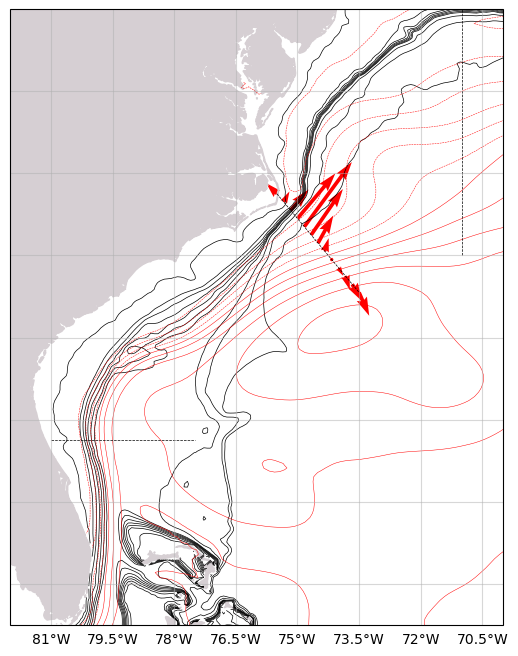

In [15]:
# check rotation and plot velocities
lon_w = -82; lon_e = -70; lat_s = 25; lat_n = 40; levs=np.arange(0,1+0.1,0.1)
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()});
ax.contour(rm_static_grids.geolon, rm_static_grids.geolat, rm_static_grids.deptho, levels=[25,100,200,300,400,500,600,1000,2000,3000],colors='k',linewidths=0.5, transform=ccrs.PlateCarree())
ax.contour(out_dict[exps[1]]['geolon'],out_dict[exps[1]]['geolat'],out_dict[exps[1]]['zos_m'],levels=np.arange(-1,1.1,0.1),colors='r',linewidths=0.35, transform=ccrs.PlateCarree())
ax.plot([-81,-77.5],[la_cross,la_cross],color='k',linestyle='--',transform=ccrs.PlateCarree(),linewidth=0.5)
ax.plot([lo_cross,lo_cross],[34,41],color='k',linestyle='--',transform=ccrs.PlateCarree(),linewidth=0.5)     
ax.plot(mid_cross_lo,mid_cross_la,color='k',linestyle='--',transform=ccrs.PlateCarree(),linewidth=0.5)
ax.quiver(mid_cross_lo[::2],mid_cross_la[::2],fi_u[30,::2],fi_v[30,::2],scale=5,color='r',transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s,lat_n]); # ax.set_title(labi[i] + ' MKE (NWA12)');
gl = ax.gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.left_labels = False; gl.right_labels = False;

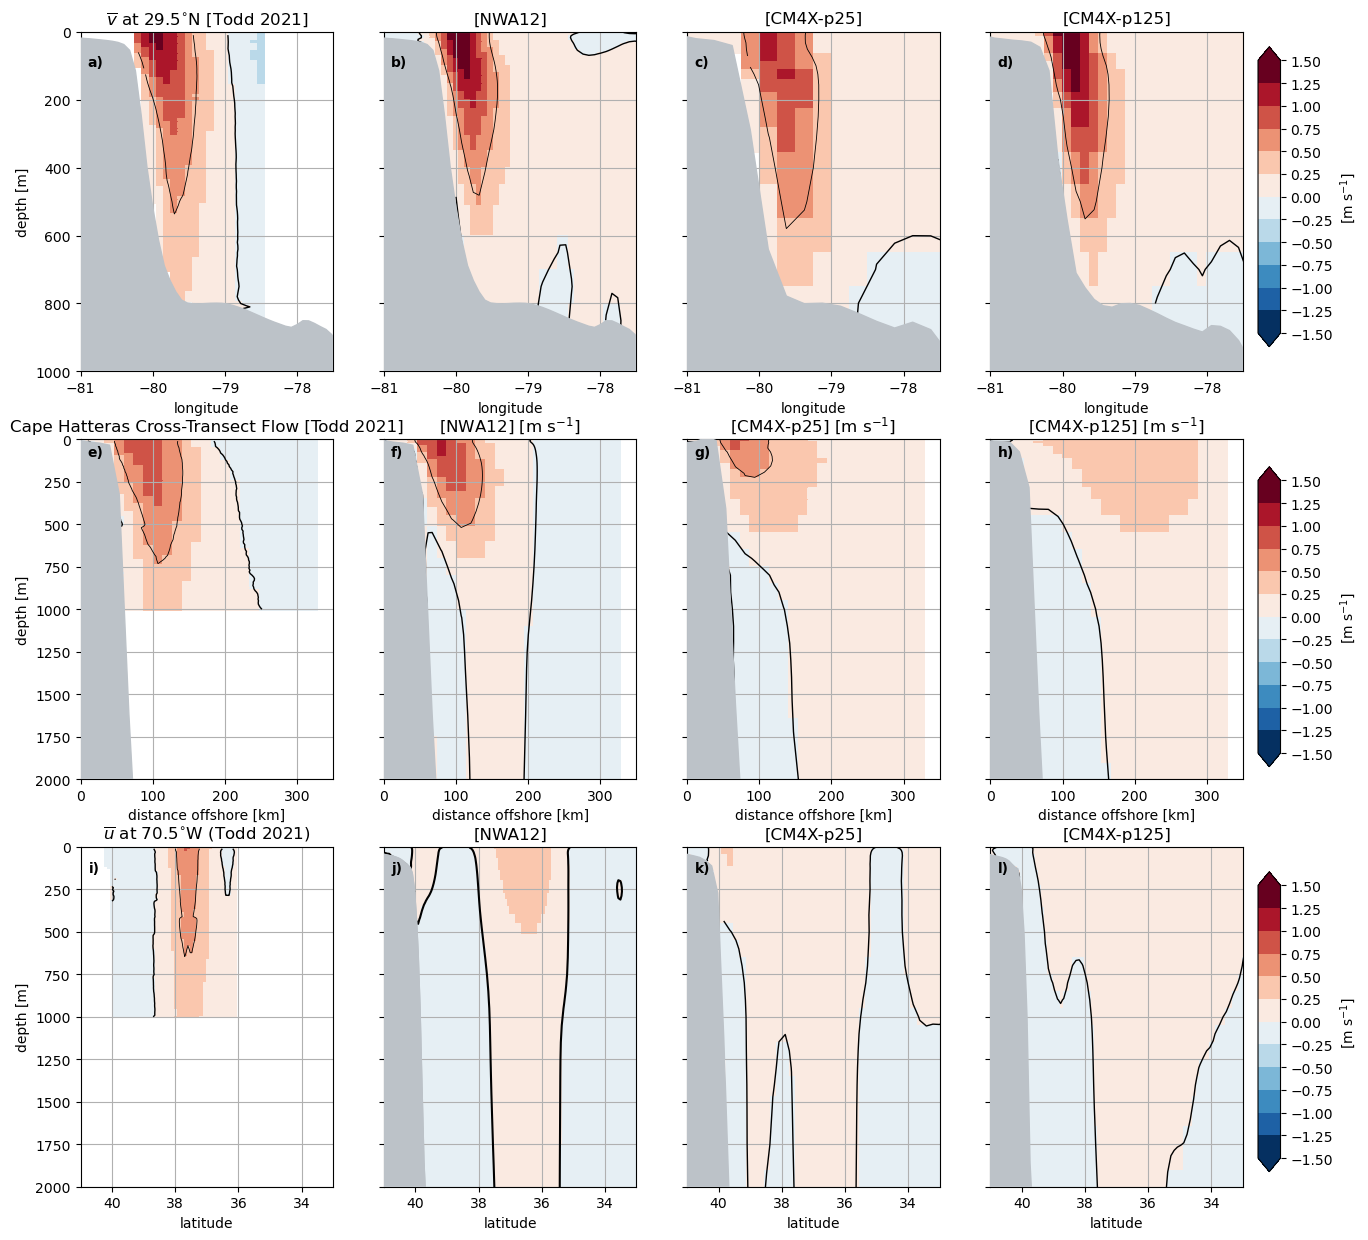

In [16]:
cmc = plt.get_cmap('RdBu_r',12)
cml = [0.001,1.5]; vml = [-1.5,1.5]
f, ax = plt.subplots(3,4,figsize=(15,15))
gax = ax.flatten()

# --------------------
la_r = 29.5
# --------------------
gax[0].pcolor(gs_mke_todd.longitude,gs_mke_todd.depth,\
              1*gs_mke_todd.northward_velocity.sel(latitude=la_r,method='nearest'),cmap=cmc, vmin=vml[0], vmax=vml[1])
gax[0].contour(gs_mke_todd.longitude,gs_mke_todd.depth,1*gs_mke_todd.northward_velocity.sel(latitude=la_r,method='nearest'),colors='k',levels=[0],linewidths=1)
gax[0].contour(gs_mke_todd.longitude,gs_mke_todd.depth,1*gs_mke_todd.northward_velocity.sel(latitude=la_r,method='nearest'),colors='k',levels=[-0.5,0.5],linewidths=0.6)
gax[0].set_ylim([0,1000]); gax[0].set_xlim([-81,-77.5]); gax[0].invert_yaxis(); gax[0].grid()
gax[0].set_ylabel('depth [m]'); gax[0].set_title(r'$\overline{v}$ at 29.5$^{\circ}$N [Todd 2021]'); gax[0].set_xlabel('longitude');

ii = np.where((rm_static_grids.geolat_v > (la_r - 0.25)) & (rm_static_grids.geolat_v < (la_r + 0.25)))
ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];
gax[1].pcolor(rm_static_grids.geolon_v.isel(yq=slice(iys,iye)).mean(dim='yq'),nwa12_vo_m.z_l,1*nwa12_vo_m.isel(yq=slice(iys,iye)).mean(dim='yq'), cmap=cmc, vmin=vml[0], vmax=vml[1])
gax[1].contour(rm_static_grids.geolon_v.isel(yq=slice(iys,iye)).mean(dim='yq'),nwa12_vo_m.z_l,1*nwa12_vo_m.isel(yq=slice(iys,iye)).mean(dim='yq'), colors='k', levels=[0], linewidths=1,zorder=2)
gax[1].contour(rm_static_grids.geolon_v.isel(yq=slice(iys,iye)).mean(dim='yq'),nwa12_vo_m.z_l,1*nwa12_vo_m.isel(yq=slice(iys,iye)).mean(dim='yq'), colors='k', levels=[-0.5,0.5], linewidths=0.6,zorder=2)
gax[1].fill_between(rm_static_grids.geolon_v.isel(yq=slice(iys,iye)).mean(dim='yq'), \
                    rm_static_grids.deptho.isel(yh=slice(iys,iye)).mean(dim='yh'), 8000, color='#bcc2c8',zorder=3)
gax[0].fill_between(rm_static_grids.geolon_v.isel(yq=slice(iys,iye)).mean(dim='yq'), \
                    rm_static_grids.deptho.isel(yh=slice(iys,iye)).mean(dim='yh'), 8000, color='#bcc2c8',zorder=3)
gax[1].set_ylim([0,1000]); gax[1].set_xlim([-81,-77.5]); gax[1].grid(); gax[1].invert_yaxis(); 
gax[1].set_title(r'[NWA12]'); gax[1].set_yticklabels(''); gax[1].set_xlabel('longitude');

for i in range(len(out_dict)):
    ii = np.where((out_dict[exps[i]]['geolat_v'] > (la_r - 0.25)) & (out_dict[exps[i]]['geolat_v'] < (la_r + 0.25)))
    ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];
    cc = gax[i+2].pcolor(out_dict[exps[i]]['geolon_v'].isel(yq=slice(iys,iye)).mean(dim='yq'), out_dict[exps[i]]['vo_m'].z_l,\
              1*out_dict[exps[i]]['vo_m'].isel(yq=slice(iys,iye)).mean(dim='yq'), cmap=cmc, vmin=vml[0], vmax=vml[1])
    gax[i+2].contour(out_dict[exps[i]]['geolon_v'].isel(yq=slice(iys,iye)).mean(dim='yq'),out_dict[exps[i]]['vo_m'].z_l,\
              1*out_dict[exps[i]]['vo_m'].isel(yq=slice(iys,iye)).mean(dim='yq'), colors='k', levels=[0], linewidths=1,zorder=2)
    gax[i+2].contour(out_dict[exps[i]]['geolon_v'].isel(yq=slice(iys,iye)).mean(dim='yq'),out_dict[exps[i]]['vo_m'].z_l,\
              1*out_dict[exps[i]]['vo_m'].isel(yq=slice(iys,iye)).mean(dim='yq'), colors='k', levels=[-0.5,0.5], linewidths=0.6,zorder=2)
    gax[i+2].fill_between(out_dict[exps[i]]['geolon_v'].isel(yq=slice(iys,iye)).mean(dim='yq'), \
                        out_dict[exps[i]]['dep'].isel(yh=slice(iys,iye)).mean(dim='yh'), \
                        8000, color='#bcc2c8',zorder=3)
    gax[i+2].set_ylim([0,1000]); gax[i+2].set_xlim([-81,-77.5]); gax[i+2].invert_yaxis(); gax[i+2].grid()
    gax[i+2].set_yticklabels('');
    gax[i+2].set_xlabel('longitude');
cbpos = [0.91, 0.67, 0.015, 0.2]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='[m s$^{-1}$]', ticks=np.arange(-1.5,1.75,0.25));
gax[2].set_title(r'[CM4X-p25]')
gax[3].set_title(r'[CM4X-p125]')

# -----------------------------------------------
# ROW TWO
H = 2000; do = 350;
c1 = gax[4].pcolor(dist/1000, gs_mke_todd.depth, -1*vpr_pot_obs, cmap=cmc,vmin=vml[0],vmax=vml[-1])
gax[4].contour(dist/1000, gs_mke_todd.depth, -1*vpr_pot_obs, levels=[0], colors='k', linewidths=1)
gax[4].contour(dist/1000, gs_mke_todd.depth, -1*vpr_pot_obs, levels=[-0.5,0.5], colors='k', linewidths=0.6)
gax[4].fill_between(dist/1000,fi_d[:,0],8000,color='#bcc2c8',zorder=3)
gax[4].grid(); gax[4].set_xlim([0,do]); gax[4].set_ylim([0,H]);
gax[4].invert_yaxis(); gax[4].set_ylabel('depth [m]'); gax[4].set_xlabel('distance offshore [km]')
gax[4].set_title('Cape Hatteras Cross-Transect Flow [Todd 2021]')

gax[5].pcolor(dist/1000, nwa12_uo_m.z_l, -1*vpr_pot, cmap=cmc,vmin=vml[0],vmax=vml[-1])
gax[5].contour(dist/1000, nwa12_uo_m.z_l, -1*vpr_pot, levels=[0], colors='k', linewidths=1)
gax[5].contour(dist/1000, nwa12_uo_m.z_l, -1*vpr_pot, levels=[-0.5,0.5], colors='k', linewidths=0.6)
gax[5].fill_between(dist/1000,fi_d[:,0],8000,color='#bcc2c8',zorder=3)
gax[5].grid(); gax[5].set_xlim([0,do]); gax[5].set_ylim([0,H]);
gax[5].invert_yaxis(); 
gax[5].set_title('[NWA12] [m s$^{-1}$]'); gax[5].set_xlabel('distance offshore [km]')
gax[5].set_yticklabels('');

gax[6].pcolor(dist/1000, out_dict[exps[0]]['uo_m'].z_l, -1*vpr_pot_cm4x[0], cmap=cmc,vmin=vml[0],vmax=vml[-1])
gax[6].contour(dist/1000, out_dict[exps[0]]['uo_m'].z_l, -1*vpr_pot_cm4x[0], levels=[0], colors='k', linewidths=1)
gax[6].contour(dist/1000, out_dict[exps[0]]['uo_m'].z_l, -1*vpr_pot_cm4x[0], levels=[-0.5,0.5], colors='k', linewidths=0.6)
gax[6].fill_between(dist/1000,fi_d_cm4x[0],8000,color='#bcc2c8',zorder=3)
gax[6].grid(); gax[6].set_xlim([0,do]); gax[6].set_ylim([0,H]);
gax[6].invert_yaxis(); 
gax[6].set_title('[CM4X-p25] [m s$^{-1}$]'); gax[6].set_xlabel('distance offshore [km]')
gax[6].set_yticklabels('');

gax[7].pcolor(dist/1000, out_dict[exps[1]]['uo_m'].z_l, -1*vpr_pot_cm4x[1], cmap=cmc,vmin=vml[0],vmax=vml[-1])
gax[7].contour(dist/1000, out_dict[exps[1]]['uo_m'].z_l, -1*vpr_pot_cm4x[1], levels=[0], colors='k', linewidths=1)
gax[7].contour(dist/1000, out_dict[exps[1]]['uo_m'].z_l, -1*vpr_pot_cm4x[1], levels=[-0.5,0.5], colors='k', linewidths=0.6)
gax[7].fill_between(dist/1000,fi_d_cm4x[1],8000,color='#bcc2c8',zorder=3)
gax[7].grid(); gax[7].set_xlim([0,do]); gax[7].set_ylim([0,H]);
gax[7].invert_yaxis(); 
gax[7].set_title('[CM4X-p125] [m s$^{-1}$]'); gax[7].set_xlabel('distance offshore [km]')
gax[7].set_yticklabels('');
cbpos = [0.91, 0.39, 0.015, 0.2]; cax = f.add_axes(cbpos); 
cb = f.colorbar(c1, cax=cax, orientation='vertical', extend='both', label='[m s$^{-1}$]', ticks=np.arange(-1.5,1.75,0.25));

# -----------------------------------------------
# ROW THREE
lo_r = -70.5; cmc = plt.get_cmap('RdBu_r',12)
# -----------------------------------------------
gax[8].pcolor(gs_mke_todd.latitude, gs_mke_todd.depth,\
              1*gs_mke_todd.eastward_velocity.sel(longitude=lo_r,method='nearest'),cmap=cmc, vmin=vml[0], vmax=vml[1])
gax[8].contour(gs_mke_todd.latitude, gs_mke_todd.depth,1*gs_mke_todd.eastward_velocity.sel(longitude=lo_r,method='nearest'),colors='k',levels=[0],linewidths=1)
gax[8].contour(gs_mke_todd.latitude, gs_mke_todd.depth,1*gs_mke_todd.eastward_velocity.sel(longitude=lo_r,method='nearest'),colors='k',levels=[-0.5,0.5],linewidths=0.6)
gax[8].set_ylim([0,2000]); gax[8].set_xlim([33, 41]); gax[8].invert_yaxis(); gax[8].grid()
gax[8].set_ylabel('depth [m]'); gax[8].set_xlabel('latitude'); 
gax[8].set_title(r'$\overline{u}$ at ' + str(-1*lo_r) + '$^{\circ}$W (Todd 2021)')
gax[8].invert_xaxis()

ii = np.where((rm_static_grids.geolon_u > (lo_r - 0.25)) & (rm_static_grids.geolon_u < (lo_r + 0.25)))
ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];
gax[9].pcolor(rm_static_grids.geolat_u.isel(xq=slice(ixs,ixe)).mean(dim='xq'), nwa12_uo_m.z_l,\
             1*nwa12_uo_m.isel(xq=slice(ixs,ixe)).mean(dim='xq'), cmap=cmc, vmin=vml[0], vmax=vml[1])
gax[9].contour(rm_static_grids.geolat_u.isel(xq=slice(ixs,ixe)).mean(dim='xq'), nwa12_uo_m.z_l,\
              1*nwa12_uo_m.isel(xq=slice(ixs,ixe)).mean(dim='xq'), colors='k', levels=[0],linewiths=1)
gax[9].contour(rm_static_grids.geolat_u.isel(xq=slice(ixs,ixe)).mean(dim='xq'), nwa12_uo_m.z_l,\
              1*nwa12_uo_m.isel(xq=slice(ixs,ixe)).mean(dim='xq'), colors='k', levels=[-0.5,0.5],linewidths=0.6)
gax[9].fill_between(rm_static_grids.geolat.isel(xh=slice(ixs,ixe)).mean(dim='xh'), \
                    rm_static_grids.deptho.isel(xh=slice(ixs,ixe)).mean(dim='xh'), 8000, color='#bcc2c8',zorder=3)
gax[9].fill_between(rm_static_grids.geolat.isel(xh=slice(ixs,ixe)).mean(dim='xh'), \
                    rm_static_grids.deptho.isel(xh=slice(ixs,ixe)).mean(dim='xh'), 8000, color='#bcc2c8',zorder=3)
gax[9].set_ylim([0,2000]); gax[9].set_xlim([33,41]); gax[9].grid(); gax[9].invert_yaxis(); 
gax[9].set_title(r'[NWA12]'); gax[9].set_yticklabels('');
gax[9].set_xlabel('latitude'); gax[9].invert_xaxis();

for i in range(len(out_dict)):
    ii = np.where((out_dict[exps[i]]['geolon_u'] > (lo_r - 0.35)) & (out_dict[exps[i]]['geolon_u'] < (lo_r + 0.35)))
    ixs = ii[1][0]; ixe = ii[1][-1]; iys = ii[0][0]; iye = ii[0][-1];
    cc = gax[i+10].pcolor(out_dict[exps[i]]['geolat_u'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), out_dict[exps[i]]['uo_m'].z_l, \
              1*out_dict[exps[i]]['uo_m'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), cmap=cmc, vmin=vml[0], vmax=vml[1], zorder=1)
    gax[i+10].contour(out_dict[exps[i]]['geolat_u'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), out_dict[exps[i]]['uo_m'].z_l,\
              1*out_dict[exps[i]]['uo_m'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), colors='k', levels=[0],zorder=2, linewidths=1)
    gax[i+10].contour(out_dict[exps[i]]['geolat_u'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), out_dict[exps[i]]['uo_m'].z_l,\
              1*out_dict[exps[i]]['uo_m'].isel(xq=slice(ixs,ixe)).mean(dim='xq'), colors='k', levels=[-0.5,0.5],zorder=2, linewidths=0.6)
    gax[i+10].fill_between(out_dict[exps[i]]['geolat'].isel(xh=slice(ixs,ixe)).mean(dim='xh'), \
                        out_dict[exps[i]]['dep'].isel(xh=slice(ixs,ixe)).mean(dim='xh'), \
                        8000, color='#bcc2c8',zorder=3)
    gax[i+10].set_ylim([0,2000]); gax[i+10].set_xlim([33,41]); gax[i+10].invert_yaxis(); gax[i+10].grid()
    gax[i+10].set_yticklabels('');
    gax[i+10].set_xlabel('latitude'); 
    gax[i+10].invert_xaxis()

cbpos = [0.91, 0.12, 0.015, 0.2]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='[m s$^{-1}$]', ticks=np.arange(-1.5,1.75,0.25));
gax[10].set_title(r'[CM4X-p25]')
gax[11].set_title(r'[CM4X-p125]')
gax[0].text(-80.9,100,'a)',fontweight='bold'); gax[1].text(-80.9,100,'b)',fontweight='bold'); gax[2].text(-80.9,100,'c)',fontweight='bold'); gax[3].text(-80.9,100,'d)',fontweight='bold'); 
gax[4].text(10,100,'e)',fontweight='bold'); gax[5].text(10,100,'f)',fontweight='bold'); gax[6].text(10,100,'g)',fontweight='bold'); gax[7].text(10,100,'h)',fontweight='bold'); 
gax[8].text(40.75,150,'i)',fontweight='bold'); gax[9].text(40.75,150,'j)',fontweight='bold'); gax[10].text(40.75,150,'k)',fontweight='bold'); gax[11].text(40.75,150,'l)',fontweight='bold');